# APPLIED DATA SCIENCE CAPSTONE PROJECT BY IBM AND COURSERA

# FINDING LOCATIONS TO OPEN A HOTEL IN KAROL BAGH ( DELHI ), INDIA

#### Table of contents
* Introduction / Business Problem
* Data
* Methodology
* Results
* Discussion
* Conclusion

# Introduction / Business Problem

The aim of this project is to find suitable locations to open a hotel in karol bagh greater metropolitan area [Karol bagh  and its suburbns],Delhi ( India ).

The first requirement is that the new hotel should be easily accessible by its prospective customers and more specifically it should be located near a metro station. The number of hotels already existing in an area should also be considered so that fierce competition be avoided if possible.

Apart from the obvious intended stakeholders, entrepreneurs looking to start a hotel business, similar methodology could be used for other specific types of businesses. It can serve as an initial starting point of locations to consider to start their business.

For the project objectives to be achieved, python geolocation libraries will be used, along with the Foursquare API. Also, in order to create clusters of similar candidate locations, the K-Means machine learning clustering algorithm will be used.



# Data


The necessary data for this project, based on the above stated requirements, are:

The metro stations in the karol bagh greater metropolitan area
Number of existing hotels near each station
In addition, the distance to the nearest hotels for every metro station will be used
In order to obtain the data, a combination of the geopy Python library and the Foursquare API will be used:

1. ‘Karol Bagh Market’ will be considered as the center of Karol Bagh,Delhi. It is indeed one of the most central location in the city. I will obtain its geospatial coordinates using the geopy library

2. Having the coordinates of the ‘center’ of Karol Bagh, the Foursquare API will be used to retrieve data for all the metro stations in Athens greater area in a radius of 15 km

3. To find the existing hotels near the metro stations, the Foursquare API will again be used for every station. I will obtain data for all the hotels located in a radius of 1000 meters of every metro station

Using the collected data, I will calculate the number of existing hotels near each station. I will also be able to determine the minimum distance to a hotel for every metro station from the 3rd step of the above process. This minimum distance to every metro station from a hotel, along with the number of already existing hotels near the station will be used as input to K-Means clustering algorithm to obtain the clusters of areas (metro stations).

# Methodology

 
The objective of this project is to obtain information about metro stations in the greater metropolitan karol bagh area with potential for opening a hotel, and having as criteria:
       * Low number of already existing hotels
       * Minimum distance of existing hotels to its nearby station



The steps I will follow to identify potential areas (metro stations) are:

* Consider ‘Karol Bagh Market’ as the center of karol bagh.
* Based on the coordinates of Karol Bagh Market, I will obtain information about metro stations in a radius of 15 km using the Foursquare API. At this stage I will remove from the above dataset points that although they are identified as ‘Metro stations’ by the Foursquare API, they are only used as depots or maintenance gathering for the metro carriages.
* After the collection of metro stations information, I will again use the Foursquare API to locate all the existing hotels in a radius of 1000 meters from each station. At this stage I will only keep as my data set the results that correspond only to 'Hotel Pool','Bed & Breakfast' and ‘Hotel’ subcategories. I will remove the rest of the subcategories such as 'Boarding House','Indian Restaurant','Motel', etc. I will ignore for the purpose of clusttering any metro stations that based on the results of the Foursquare API don’t have any existing hotels in their vicinity. For those, there can either be no existing data in the Foursquare database, or indeed there no existing hotels near the corresponding station. The data set will also contain the distance of each hotel to the corresponding station.
* Having the information about hotels around metro stations, I will calculate the number of existing hotels near each station as well as the minimum distance from each station to a hotel using available python statistical functions.
* The data will be normalized so that both factors (minimum distance, number of existing hotels) will have equal weight when they will be used by a machine learning method.
* The K-Means Machine Learning clustering algorithm will be used to divide the stations and hotels data set into clusters of similar locations. The elbow method will be used to find the most suitable number of clusters.
* From that cluster we can decide the most suitable location in that area

##### for first time we have to install 
* !conda install -c conda-forge geopy --yes
* !conda install -c conda-forge folium --yes

#### Installing Package

In [1]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!conda install -c conda-forge folium --yes

Solving environment: ...working... done

# All requested packages already installed.



##### importing liberary

In [3]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import pandas as pd
# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from pandas.io.json import json_normalize

import folium # map rendering library

import requests

import numpy as np
import pandas as pd 
# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns 
from matplotlib.pyplot import subplots

from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


## Data Cleaning 

##### for collecting data near Karol Bagh Market, Delhi area we have to do  web scrapping

In [4]:

address =  'Karol Bagh Market, Delhi'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Syntagma Metro Station are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Syntagma Metro Station are 28.6529982, 77.1890227.


In [5]:
string = str(latitude) + ', ' +str(longitude)
address = geolocator.reverse(string, language='en')
address

Location(52, Karol Bagh, Karol Bagh Tehsil, Central Delhi, Delhi, 110005, India, (28.65288017339733, 77.18918488666283, 0.0))

* Let's show 'Karol Bagh Market' on a map

In [6]:

map_syntagma = folium.Map(location=[latitude, longitude], zoom_start=18)
folium.Marker([latitude, longitude], popup='Karol Bagh Market').add_to(map_syntagma)
map_syntagma

##### Have to find places near th metro area so searching places near it


Category id for metro stations: 4bf58dd8d48988d1fd931735

Source: https://developer.foursquare.com/docs/resources/categories



In [7]:
metro='4bf58dd8d48988d1fd931735'

In [8]:
print('category id for metro station ',metro)

category id for metro station  4bf58dd8d48988d1fd931735


#### Get the metro stations in Karol bagh in radius of 15 km around Karol Bagh Market

In [9]:
radius = 15000
CLIENT_ID='DHBE22VPGL02ZITFEVU31JVYCV0SZJ3EGFHIUMRTKRTE4VIJ'
CLIENT_SECRET='MCUC5VDGQMKFR40MMXYOWRDRGYUCPCA4MHIKRMGYW2DX0VGZ'
VERSION = '20190425' # Foursquare API version
LIMIT = 200
category_id = '4bf58dd8d48988d1fd931735' # Metro Stations

In [10]:
url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius,
    LIMIT
)

In [11]:

# stations_list = results['response']['groups'][0]['items']
stations_list = requests.get(url).json()['response']['groups'][0]['items']
stations_init_df = json_normalize(stations_list)

stations_init_df.head(2)

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",e-0-4bfb91411134b71357a70fc9-0,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",4bfb91411134b71357a70fc9,"Rajiv Chowk, Inner Circle, Connaught Place",IN,New Delhi,India,NaN,3702,"[Rajiv Chowk, Inner Circle, Connaught Place, New Delhi 110001, Delhi, India]","[{'label': 'display', 'lat': 28.632980562212612, 'lng': 77.21928786545695}]",28.632981,77.219288,NaN,110001,Delhi,Rajiv Chowk | राजीव चौक Metro Station,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",e-0-4c177680216fc9b6c96b8f96-1,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",4c177680216fc9b6c96b8f96,New Delhi Railway Station,IN,New Delhi,India,NaN,3540,"[New Delhi Railway Station, New Delhi 110001, Delhi, India]","[{'label': 'display', 'lat': 28.64280345814337, 'lng': 77.2233510017395}]",28.642803,77.223351,NaN,110001,Delhi,New Delhi | नई दिल्ली Metro Station,0,[],NaN


In [12]:

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.postalCode']
stations_filtered_df = stations_init_df.loc[:, filtered_columns]

# filter the category for each row
stations_filtered_df['venue_type'] = stations_init_df['venue.categories'].apply(lambda x: dict(x[0])['name'])

# clean columns
stations_filtered_df.columns = [col.split('.')[-1] for col in stations_filtered_df.columns]

stations_df = stations_filtered_df[stations_filtered_df['venue_type'] == 'Metro Station']
stations_df = stations_df.drop('categories', axis=1)
stations_df.head()

,name,lat,lng,distance,postalCode,venue_type
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,3702,110001,Metro Station
1,New Delhi | नई दिल्ली Metro Station,28.642803,77.223351,3540,110001,Metro Station
2,Central Secretariat Metro Station,28.615908,77.212558,4725,NaN,Metro Station
4,Kirti Nagar Metro Station,28.654676,77.151075,3711,NaN,Metro Station
5,Kashmere Gate Metro Station,28.667746,77.228304,4173,NaN,Metro Station


In [13]:
stations_df.shape

(43, 6)

In [14]:
stations_df[stations_df['name'].str.find('Station') == -1]

,name,lat,lng,distance,postalCode,venue_type
11,Pulbangsh metro station,28.666416,77.207429,2337,NaN,Metro Station
26,Udyog Bhawan,28.609466,77.211871,5335,110001,Metro Station
39,Dhaula Kuan Airport Express,28.592133,77.161548,7287,NaN,Metro Station
53,South ex,28.559267,77.218605,10827,NaN,Metro Station
56,Janakpuri West Metro station,28.629364,77.077986,11162,NaN,Metro Station



##### Keep only the stations that their name contains 'Station' 

In [15]:

# Keep only the stations that their name contains 'Station' 
stations_df = stations_df[stations_df['name'].str.contains('Station')]
stations_df.shape

(38, 6)

* changing name to proper format

In [16]:

stations_df['name'] = stations_df['name'].apply(lambda x: x.split('(')[0]).str.strip()

fixed_columns = [stations_df.columns[0]] + [stations_df.columns[-1]] + list(stations_df.columns[1:-1])
stations_df = stations_df[fixed_columns]
stations_df.head(10)

,name,venue_type,lat,lng,distance,postalCode
0,Rajiv Chowk | राजीव चौक Metro Station,Metro Station,28.632981,77.219288,3702,110001
1,New Delhi | नई दिल्ली Metro Station,Metro Station,28.642803,77.223351,3540,110001
2,Central Secretariat Metro Station,Metro Station,28.615908,77.212558,4725,NaN
4,Kirti Nagar Metro Station,Metro Station,28.654676,77.151075,3711,NaN
5,Kashmere Gate Metro Station,Metro Station,28.667746,77.228304,4173,NaN
8,Barakhamba Road Metro Station,Metro Station,28.629993,77.223830,4256,NaN
9,Vishwavidyalaya Metro Station,Metro Station,28.695030,77.214718,5309,110007
10,Patel Nagar Metro Station,Metro Station,28.645115,77.169256,2121,110008
13,Patel Chowk Metro Station,Metro Station,28.622511,77.213679,4161,NaN
14,Janpath Metro Station,Metro Station,28.624426,77.219187,4336,NaN


##### checking the null values in dataset

In [17]:
stations_df.isnull().sum()

name          0 
venue_type    0 
lat           0 
lng           0 
distance      0 
postalCode    24
dtype: int64

###### checking the value counts

In [18]:
stations_df['postalCode'].value_counts()

110001    2
110017    1
110007    1
110059    1
110037    1
110018    1
110006    1
110003    1
110008    1
110096    1
110015    1
110024    1
110009    1
Name: postalCode, dtype: int64

##### Filling postal code with original value 
* use google for checking postal code

In [19]:
stations_df.iloc[2]=stations_df.iloc[2].replace(np.nan,'110001')

In [20]:
stations_df.iloc[4]

name          Kashmere Gate Metro Station
venue_type    Metro Station              
lat           28.6677                    
lng           77.2283                    
distance      4173                       
postalCode    NaN                        
Name: 5, dtype: object

In [21]:
stations_df.iloc[3]=stations_df.iloc[3].replace(np.nan,'110015')

In [22]:
stations_df.iloc[4]=stations_df.iloc[4].replace(np.nan,'110006')

In [23]:
stations_df.iloc[5]=stations_df.iloc[5].replace(np.nan,'110001')

In [24]:
stations_df.iloc[13]

name          Shastri Park Metro Station
venue_type    Metro Station             
lat           28.6684                   
lng           77.2506                   
distance      6251                      
postalCode    NaN                       
Name: 20, dtype: object

In [25]:
stations_df.iloc[8]=stations_df.iloc[8].replace(np.nan,'110001')
stations_df.iloc[9]=stations_df.iloc[9].replace(np.nan,'110001')
stations_df.iloc[10]=stations_df.iloc[10].replace(np.nan,'110015')
stations_df.iloc[13]=stations_df.iloc[13].replace(np.nan,'110054')
stations_df.iloc[14]=stations_df.iloc[14].replace(np.nan,'110021')


In [26]:
stations_df.head(15)

,name,venue_type,lat,lng,distance,postalCode
0,Rajiv Chowk | राजीव चौक Metro Station,Metro Station,28.632981,77.219288,3702,110001
1,New Delhi | नई दिल्ली Metro Station,Metro Station,28.642803,77.223351,3540,110001
2,Central Secretariat Metro Station,Metro Station,28.615908,77.212558,4725,110001
4,Kirti Nagar Metro Station,Metro Station,28.654676,77.151075,3711,110015
5,Kashmere Gate Metro Station,Metro Station,28.667746,77.228304,4173,110006
8,Barakhamba Road Metro Station,Metro Station,28.629993,77.223830,4256,110001
9,Vishwavidyalaya Metro Station,Metro Station,28.695030,77.214718,5309,110007
10,Patel Nagar Metro Station,Metro Station,28.645115,77.169256,2121,110008
13,Patel Chowk Metro Station,Metro Station,28.622511,77.213679,4161,110001
14,Janpath Metro Station,Metro Station,28.624426,77.219187,4336,110001


In [27]:
stations_df.iloc[25]

name          Hauz Khas | हौज खास Metro Station
venue_type    Metro Station                    
lat           28.544                           
lng           77.2063                          
distance      12252                            
postalCode    NaN                              
Name: 45, dtype: object

In [28]:
stations_df.iloc[17]=stations_df.iloc[17].replace(np.nan,'110006')
stations_df.iloc[20]=stations_df.iloc[20].replace(np.nan,'110003')
stations_df.iloc[21]=stations_df.iloc[21].replace(np.nan,'110034')
stations_df.iloc[22]=stations_df.iloc[22].replace(np.nan,'110014')
stations_df.iloc[24]=stations_df.iloc[24].replace(np.nan,'110053')

In [29]:
stations_df.head(25)

,name,venue_type,lat,lng,distance,postalCode
0,Rajiv Chowk | राजीव चौक Metro Station,Metro Station,28.632981,77.219288,3702,110001
1,New Delhi | नई दिल्ली Metro Station,Metro Station,28.642803,77.223351,3540,110001
2,Central Secretariat Metro Station,Metro Station,28.615908,77.212558,4725,110001
4,Kirti Nagar Metro Station,Metro Station,28.654676,77.151075,3711,110015
5,Kashmere Gate Metro Station,Metro Station,28.667746,77.228304,4173,110006
8,Barakhamba Road Metro Station,Metro Station,28.629993,77.223830,4256,110001
9,Vishwavidyalaya Metro Station,Metro Station,28.695030,77.214718,5309,110007
10,Patel Nagar Metro Station,Metro Station,28.645115,77.169256,2121,110008
13,Patel Chowk Metro Station,Metro Station,28.622511,77.213679,4161,110001
14,Janpath Metro Station,Metro Station,28.624426,77.219187,4336,110001


In [30]:
stations_df.iloc[25]=stations_df.iloc[25].replace(np.nan,'110016')
stations_df.iloc[26]=stations_df.iloc[26].replace(np.nan,'110092')
stations_df.iloc[27]=stations_df.iloc[27].replace(np.nan,'212201')
stations_df.iloc[28]=stations_df.iloc[28].replace(np.nan,'110058')
stations_df.iloc[30]=stations_df.iloc[30].replace(np.nan,'110032')
stations_df.iloc[31]=stations_df.iloc[31].replace(np.nan,'110095')
stations_df.iloc[32]=stations_df.iloc[32].replace(np.nan,'110095')
stations_df.iloc[33]=stations_df.iloc[33].replace(np.nan,'110037')
stations_df.iloc[36]=stations_df.iloc[36].replace(np.nan,'110037')
stations_df.iloc[37]=stations_df.iloc[37].replace(np.nan,'110037')

In [31]:
stations_df.tail(15)

,name,venue_type,lat,lng,distance,postalCode
42,Tilak Nagar Metro Station,Metro Station,28.636513,77.096429,9230,110018
43,Seelampur Metro Station,Metro Station,28.669805,77.266846,7828,110053
45,Hauz Khas | हौज खास Metro Station,Metro Station,28.543979,77.206263,12252,110016
47,Akshardham Metro Station,Metro Station,28.618362,77.283052,9963,110092
48,Kaushambi Metro Station,Metro Station,28.645475,77.324144,13226,212201
50,Janak Puri East Metro Station,Metro Station,28.632935,77.086751,10238,110058
51,Indira Gandhi International Airport Metro Station,Metro Station,28.555696,77.086223,14773,110037
58,Shahdara Metro Station,Metro Station,28.673344,77.289011,10025,110032
60,Jhilmil Metro Station,Metro Station,28.675876,77.312309,12308,110095
62,Mansarover Park Metro Station,Metro Station,28.675370,77.300932,11210,110095


##### checking the data after feeling all postal code

In [32]:

stations_df

,name,venue_type,lat,lng,distance,postalCode
0,Rajiv Chowk | राजीव चौक Metro Station,Metro Station,28.632981,77.219288,3702,110001
1,New Delhi | नई दिल्ली Metro Station,Metro Station,28.642803,77.223351,3540,110001
2,Central Secretariat Metro Station,Metro Station,28.615908,77.212558,4725,110001
4,Kirti Nagar Metro Station,Metro Station,28.654676,77.151075,3711,110015
5,Kashmere Gate Metro Station,Metro Station,28.667746,77.228304,4173,110006
8,Barakhamba Road Metro Station,Metro Station,28.629993,77.223830,4256,110001
9,Vishwavidyalaya Metro Station,Metro Station,28.695030,77.214718,5309,110007
10,Patel Nagar Metro Station,Metro Station,28.645115,77.169256,2121,110008
13,Patel Chowk Metro Station,Metro Station,28.622511,77.213679,4161,110001
14,Janpath Metro Station,Metro Station,28.624426,77.219187,4336,110001


* Some final changes

In [33]:

stations_df.rename(columns={'name': 'station',
                            'distance': 'Distance from Center',
                            'postalCode': 'Postal Code',
                            'venue_type': 'Venue Type'},
                   inplace=True)

stations_df.reset_index(drop=True, inplace=True)

print(stations_df.info())
stations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 6 columns):
station                 38 non-null object
Venue Type              38 non-null object
lat                     38 non-null float64
lng                     38 non-null float64
Distance from Center    38 non-null int64
Postal Code             38 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 1.9+ KB
None


,station,Venue Type,lat,lng,Distance from Center,Postal Code
0,Rajiv Chowk | राजीव चौक Metro Station,Metro Station,28.632981,77.219288,3702,110001
1,New Delhi | नई दिल्ली Metro Station,Metro Station,28.642803,77.223351,3540,110001
2,Central Secretariat Metro Station,Metro Station,28.615908,77.212558,4725,110001
3,Kirti Nagar Metro Station,Metro Station,28.654676,77.151075,3711,110015
4,Kashmere Gate Metro Station,Metro Station,28.667746,77.228304,4173,110006


* Visualize the metro stations on a map of Karol Bagh

In [34]:
# create map of Athens using latitude and longitude values
map_athens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, station in zip(stations_df['lat'],
                          stations_df['lng'],
                          stations_df['station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_athens)
    
map_athens


Get the hotels near the stations

Category id for metro stations: 4bf58dd8d48988d175941735

Source: https://developer.foursquare.com/docs/resources/categories

* Function to create a dataframe with the results gathered from Foursquare API on a specific category

In [35]:
def getNearbyhotels(categoryId, stations, latitudes, longitudes, radius=1000):  
    
    print('Finding Hotels near Karol Bagh Market (Delhi), please wait...\n')
    
    hotel_list=[]
    for station, lat, lng in zip(stations, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby gym
        hotel_list.append([(
            station,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']
        ) for v in results])

    nearby_hotel = pd.DataFrame([item for venue_list in hotel_list for item in venue_list])
    nearby_hotel.columns = [
                  'station',
                  'lat',
                  'lng',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Distance from Station',
                  'Venue Category']
    print('Finished,please check your data ')
    return(nearby_hotel)


* Use the function to gather information about existing hotels in a radius of 1000m around each metro station in Karol Bagh

In [36]:

categoryId = '4bf58dd8d48988d1fa931735' # Hotels
hotels_venues_df = getNearbyhotels(categoryId, stations=stations_df['station'], latitudes=stations_df['lat'],
                         longitudes=stations_df['lng'])

Finding Hotels near Karol Bagh Market (Delhi), please wait...

Finished,please check your data 


In [37]:
hotels_venues_df.head()


,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Imperial,28.625548,77.218664,829,Hotel
1,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Lalit Hotel,28.631110,77.227450,824,Hotel
2,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Radisson Blu Marina Hotel,28.633897,77.217241,224,Hotel
3,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Aman International,28.641515,77.216148,998,Hotel
4,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,"Hotel Palace Heights, Delhi, India",28.633862,77.221449,232,Hotel


In [38]:
hotels_venues_df.shape

(207, 8)

* checking count of each type of hotel 

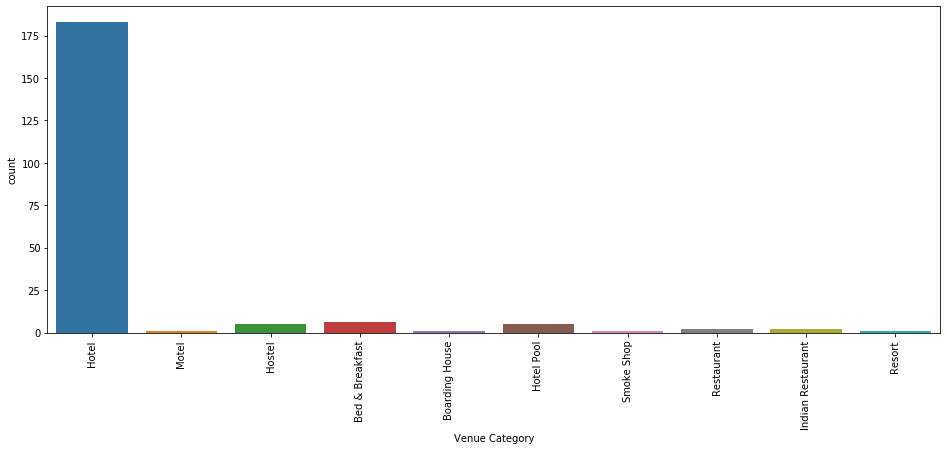

In [39]:
plt.figure(figsize=(16,6))
sns.countplot(hotels_venues_df['Venue Category'])
plt.xticks(rotation=90)
plt.show()

* let's check the categories of venues that were returned for each neighborhood

In [40]:
hotels_venues_df.groupby(['Venue Category']).count()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Bed & Breakfast,6,6,6,6,6,6,6
Boarding House,1,1,1,1,1,1,1
Hostel,5,5,5,5,5,5,5
Hotel,183,183,183,183,183,183,183
Hotel Pool,5,5,5,5,5,5,5
Indian Restaurant,2,2,2,2,2,2,2
Motel,1,1,1,1,1,1,1
Resort,1,1,1,1,1,1,1
Restaurant,2,2,2,2,2,2,2


##### We will only keep the three categories [Hotel,Hotel Pool and Bed & Breakfast]

In [41]:

hotels_venues_df = hotels_venues_df[hotels_venues_df['Venue Category'].isin(['Hotel', 'Hotel Pool','Bed & Breakfast'])]
hotels_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Imperial,28.625548,77.218664,829,Hotel
1,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Lalit Hotel,28.631110,77.227450,824,Hotel
2,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Radisson Blu Marina Hotel,28.633897,77.217241,224,Hotel
3,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Aman International,28.641515,77.216148,998,Hotel
4,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,"Hotel Palace Heights, Delhi, India",28.633862,77.221449,232,Hotel


In [42]:
hotels_venues_df.shape

(194, 8)

* Make sure that the not needed venues were removed

In [43]:
hotels_venues_df.groupby(['Venue Category']).count().head(10)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Bed & Breakfast,6,6,6,6,6,6,6
Hotel,183,183,183,183,183,183,183
Hotel Pool,5,5,5,5,5,5,5


##### Add distance from each metro station to the nearest Hotel and number of existing Hotels in its vicinity
* Add to the data frame the minimum distance of every station to the hotes in its vicinity

In [44]:
hotels_mindistance_df = pd.merge(hotels_venues_df,
                              pd.DataFrame(hotels_venues_df.groupby('station')['Distance from Station'].min()),
                              on='station', how='inner')

In [45]:
hotels_mindistance_df.head(10)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Imperial,28.625548,77.218664,829,Hotel,167
1,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Lalit Hotel,28.631110,77.227450,824,Hotel,167
2,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Radisson Blu Marina Hotel,28.633897,77.217241,224,Hotel,167
3,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Aman International,28.641515,77.216148,998,Hotel,167
4,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,"Hotel Palace Heights, Delhi, India",28.633862,77.221449,232,Hotel,167
5,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Corus Hotel New Delhi,28.634237,77.218345,167,Hotel,167
6,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Palace Heights,28.633824,77.221482,234,Hotel,167
7,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Jukaso Inn,28.634011,77.221876,277,Hotel,167
8,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Alka,28.632440,77.215976,329,Hotel,167
9,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Bright Hotel New Delhi,28.632990,77.222819,345,Hotel,167


* Add the number of already existing hotels in the vicinity of each station

In [46]:

hotels_mincount_df = pd.merge(hotels_mindistance_df,
                           pd.DataFrame(hotels_mindistance_df.groupby(['station']).count())['lat'],
                           on='station', how='inner')

In [47]:
hotels_mincount_df.head()

,station,lat_x,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y,lat_y
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Imperial,28.625548,77.218664,829,Hotel,167,19
1,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Lalit Hotel,28.631110,77.227450,824,Hotel,167,19
2,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Radisson Blu Marina Hotel,28.633897,77.217241,224,Hotel,167,19
3,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Aman International,28.641515,77.216148,998,Hotel,167,19
4,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,"Hotel Palace Heights, Delhi, India",28.633862,77.221449,232,Hotel,167,19


* Give appropriate names to the dataframe columns

In [48]:

Hotels = hotels_mincount_df.rename(columns={'lat_x': 'lat', 'Distance from Station_x': 'Distance from Station',
                                                   'Distance from Station_y': 'Min Distance from Station',
                                                   'lat_y': 'Hotels Count'})
Hotels.head(15)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category,Min Distance from Station,Hotels Count
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Imperial,28.625548,77.218664,829,Hotel,167,19
1,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Lalit Hotel,28.631110,77.227450,824,Hotel,167,19
2,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Radisson Blu Marina Hotel,28.633897,77.217241,224,Hotel,167,19
3,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Aman International,28.641515,77.216148,998,Hotel,167,19
4,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,"Hotel Palace Heights, Delhi, India",28.633862,77.221449,232,Hotel,167,19
5,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,The Corus Hotel New Delhi,28.634237,77.218345,167,Hotel,167,19
6,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Palace Heights,28.633824,77.221482,234,Hotel,167,19
7,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Jukaso Inn,28.634011,77.221876,277,Hotel,167,19
8,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Hotel Alka,28.632440,77.215976,329,Hotel,167,19
9,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,Bright Hotel New Delhi,28.632990,77.222819,345,Hotel,167,19


In [49]:
Hotels.shape

(194, 10)

##### We will keep only the necessary columns

In [50]:
Hotels = Hotels[['station', 'lat', 'lng', 'Min Distance from Station', 'Hotels Count']].drop_duplicates()


In [51]:
Hotels.head(10)

,station,lat,lng,Min Distance from Station,Hotels Count
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,167,19
19,New Delhi | नई दिल्ली Metro Station,28.642803,77.223351,205,29
48,Central Secretariat Metro Station,28.615908,77.212558,621,9
57,Kashmere Gate Metro Station,28.667746,77.228304,759,1
58,Barakhamba Road Metro Station,28.629993,77.223830,267,13
71,Patel Nagar Metro Station,28.645115,77.169256,345,6
77,Patel Chowk Metro Station,28.622511,77.213679,347,12
89,Janpath Metro Station,28.624426,77.219187,135,14
103,Jama Masjid Metro Station,28.649631,77.237812,536,5
108,Race Course Metro Station,28.596674,77.211206,692,2


In [52]:
Hotels.shape

(24, 5)

* It seems that we are missing 14 stations from the original. They probably did not have any hotels in their vicinity or there are no data available for these stations. We need to keep them in mind for any future further investigation. For now these 14 stations will be ignored

* We will merge the initial stations_df dataframe with the previously created dataframe and assign 10000 to 'Min Distance from Station' and 0 to 'hotels Count'

##### Checking the missing data

In [53]:
missing_stations_df = pd.merge(stations_df[['station', 'lat', 'lng']], Hotels,
                                    on='station', how='left')
missing_stations_df[missing_stations_df['Hotels Count'].isnull()]

,station,lat_x,lng_x,lat_y,lng_y,Min Distance from Station,Hotels Count
3,Kirti Nagar Metro Station,28.654676,77.151075,NaN,NaN,NaN,NaN
6,Vishwavidyalaya Metro Station,28.695030,77.214718,NaN,NaN,NaN,NaN
10,Moti Nagar Metro Station,28.657830,77.142445,NaN,NaN,NaN,NaN
12,Ramesh Nagar Metro Station,28.652722,77.131657,NaN,NaN,NaN,NaN
13,Shastri Park Metro Station,28.668430,77.250559,NaN,NaN,NaN,NaN
16,Mayur Vihar Phase I Metro Station,28.604851,77.289577,NaN,NaN,NaN,NaN
17,Dhaula Kuan Airport Metro Express Station,28.591429,77.161017,NaN,NaN,NaN,NaN
20,Jor Bagh Metro Station,28.585828,77.213219,NaN,NaN,NaN,NaN
21,Pitampura Metro Station,28.703198,77.132263,NaN,NaN,NaN,NaN
23,Tilak Nagar Metro Station,28.636513,77.096429,NaN,NaN,NaN,NaN


##### So the seneteen metro stations for which no data were returned from the Foursquare API are:

* Kirti Nagar Metro Stationn
* Kashmere Gate Metro Station
* Vishwavidyalaya Metro Station
* Moti Nagar Metro Station
* Ramesh Nagar Metro Station
* Shastri Park Metro Station
* Mayur Vihar Phase I Metro Station 
* Dhaula Kuan Airport Metro Express Station
* Azadpur | आजादपुर Metro Station
* Jor Bagh Metro Station
* Pitampura Metro Station
* Tilak Nagar Metro Station
* Seelampur Metro Station
* Akshardham Metro Station
* Janak Puri East Metro Station
* Shahdara Metro Station
* Jhilmil Metro Station

### Making copy of data which we reuired 

In [54]:
hotel_df=Hotels.copy()

In [55]:
hotel_df.head(10)

,station,lat,lng,Min Distance from Station,Hotels Count
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,167,19
19,New Delhi | नई दिल्ली Metro Station,28.642803,77.223351,205,29
48,Central Secretariat Metro Station,28.615908,77.212558,621,9
57,Kashmere Gate Metro Station,28.667746,77.228304,759,1
58,Barakhamba Road Metro Station,28.629993,77.223830,267,13
71,Patel Nagar Metro Station,28.645115,77.169256,345,6
77,Patel Chowk Metro Station,28.622511,77.213679,347,12
89,Janpath Metro Station,28.624426,77.219187,135,14
103,Jama Masjid Metro Station,28.649631,77.237812,536,5
108,Race Course Metro Station,28.596674,77.211206,692,2


### Normalize Data [Min Distance from Station, Gym Count]

In [56]:

print('All stations mean distance from any hotel: ', hotel_df['Min Distance from Station'].mean())
print('All stations maximum distance from any hotel: ',hotel_df['Min Distance from Station'].max())
print('All stations minimum distance from any hotel: ', hotel_df['Min Distance from Station'].min())
print('All stations mean of number of existing hotel: ', hotel_df['Hotels Count'].mean())
print('All stations maximum number of existing hotel: ', hotel_df['Hotels Count'].max())
print('All stations minimum number of existing hotel: ', hotel_df['Hotels Count'].min())


All stations mean distance from any hotel:  410.5833333333333
All stations maximum distance from any hotel:  993
All stations minimum distance from any hotel:  25
All stations mean of number of existing hotel:  8.083333333333334
All stations maximum number of existing hotel:  29
All stations minimum number of existing hotel:  1


In [57]:

hotel_df['Norm Min Distance from Station'] = (hotel_df['Min Distance from Station'] - \
                                                              hotel_df['Min Distance from Station'].mean()) / \
                                                             (hotel_df['Min Distance from Station'].max() - \
                                                              hotel_df['Min Distance from Station'].min())
hotel_df['Norm hotel Count'] = (hotel_df['Hotels Count'] - hotel_df['Hotels Count'].mean()) / \
                                             (hotel_df['Hotels Count'].max() - hotel_df['Hotels Count'].min())

In [58]:

hotel_df['Hotels Count'] = hotel_df['Hotels Count'].astype(int)

In [59]:
hotel_df.reset_index(drop=True, inplace=True)

In [60]:
hotel_df.head(15)

,station,lat,lng,Min Distance from Station,Hotels Count,Norm Min Distance from Station,Norm hotel Count
0,Rajiv Chowk | राजीव चौक Metro Station,28.632981,77.219288,167,19,-0.251636,0.389881
1,New Delhi | नई दिल्ली Metro Station,28.642803,77.223351,205,29,-0.212379,0.747024
2,Central Secretariat Metro Station,28.615908,77.212558,621,9,0.217373,0.032738
3,Kashmere Gate Metro Station,28.667746,77.228304,759,1,0.359935,-0.252976
4,Barakhamba Road Metro Station,28.629993,77.223830,267,13,-0.148330,0.175595
5,Patel Nagar Metro Station,28.645115,77.169256,345,6,-0.067751,-0.074405
6,Patel Chowk Metro Station,28.622511,77.213679,347,12,-0.065685,0.139881
7,Janpath Metro Station,28.624426,77.219187,135,14,-0.284694,0.211310
8,Jama Masjid Metro Station,28.649631,77.237812,536,5,0.129563,-0.110119
9,Race Course Metro Station,28.596674,77.211206,692,2,0.290720,-0.217262


# K-Mean Clustering

##### Prepare the dataframe to be used in K-Means algorithm

In [61]:
hotel_cluster = hotel_df.drop(['station', 'lat', 'lng', 'Min Distance from Station', 'Hotels Count'], 1)

In [62]:
hotel_cluster.shape

(24, 2)

In [63]:
hotel_cluster

,Norm Min Distance from Station,Norm hotel Count
0,-0.251636,0.389881
1,-0.212379,0.747024
2,0.217373,0.032738
3,0.359935,-0.252976
4,-0.148330,0.175595
5,-0.067751,-0.074405
6,-0.065685,0.139881
7,-0.284694,0.211310
8,0.129563,-0.110119
9,0.290720,-0.217262


##### Cluster Locations near Karol Bagh Market (Delhi) (K-Means Clustering)
###### The KMeans class has many parameters that can be used, but we will be using these three:

* init: Initialization method of the centroids.
    1. Value will be: "k-means++"
    2. k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.
        
* n_clusters: The number of clusters to form as well as the number of centroids to generate.
    1.Value will be: 4 (since we have 4 centers)
        
* n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
    1.Value will be: 12

##### Use the Elbow method to find the best k for clustering

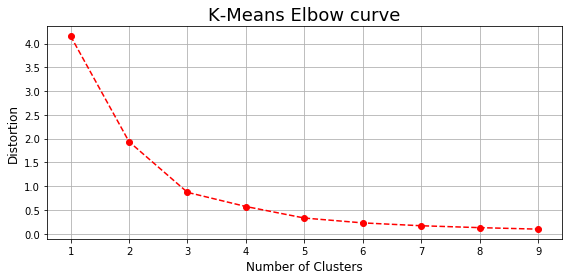

In [64]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(1, 10):
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init = 12, max_iter=300, tol=0.00001)
    kmeans.fit(hotel_cluster)
    distorsions.append(kmeans.inertia_)

fig, ax = subplots(figsize=(8, 4))
ax.plot(range(1, 10), distorsions, '--ro')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Distortion', fontsize=12)
plt.grid(True)
plt.title('K-Means Elbow curve', fontsize='18')
plt.tight_layout()
plt.show()

* The elbow graph, although not very steep, presents an elbow point at 3 number of clusters.

##### Run k-means to cluster the station areas to 3 clusters

In [65]:

# venues_grouped_clustering_df = venues_grouped_df.drop('station', 1)
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=0, n_init = 12, max_iter=300, tol=0.0001)
kmeans.fit(hotel_cluster)

kmeans.labels_

array([2, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 2, 1, 0,
       0, 2])

# K-Means Clustering Results

##### Create a new dataframe that includes the resulted clusters and relevant metro station information

In [66]:

# add clustering labels
hotel_df.insert(1, 'Cluster Label', kmeans.labels_)
hotel_df.head()

,station,Cluster Label,lat,lng,Min Distance from Station,Hotels Count,Norm Min Distance from Station,Norm hotel Count
0,Rajiv Chowk | राजीव चौक Metro Station,2,28.632981,77.219288,167,19,-0.251636,0.389881
1,New Delhi | नई दिल्ली Metro Station,2,28.642803,77.223351,205,29,-0.212379,0.747024
2,Central Secretariat Metro Station,1,28.615908,77.212558,621,9,0.217373,0.032738
3,Kashmere Gate Metro Station,1,28.667746,77.228304,759,1,0.359935,-0.252976
4,Barakhamba Road Metro Station,0,28.629993,77.223830,267,13,-0.148330,0.175595


###### Visualize the metro stations clusters on a map of Karol Bagh

In [67]:
cluster_colors = ['red', 'green', 'blue'] 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

markers_colors = []
for lat, lon, poi, cluster in zip(hotel_df['lat'], hotel_df['lng'], 
                                  hotel_df['station'], hotel_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_colors[cluster],
        fill=True,
        fill_color=cluster_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

* checking count of each cluster

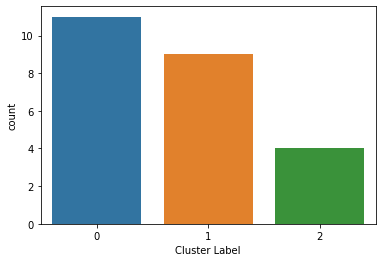

In [68]:
sns.countplot(hotel_df['Cluster Label'])
plt.show()

In [69]:
hotel_df['Cluster Label'].value_counts()

0    11
1    9 
2    4 
Name: Cluster Label, dtype: int64

##### Now visualize the (normalized) clusters distribution on a scatter plot along with their final corresponding centroids

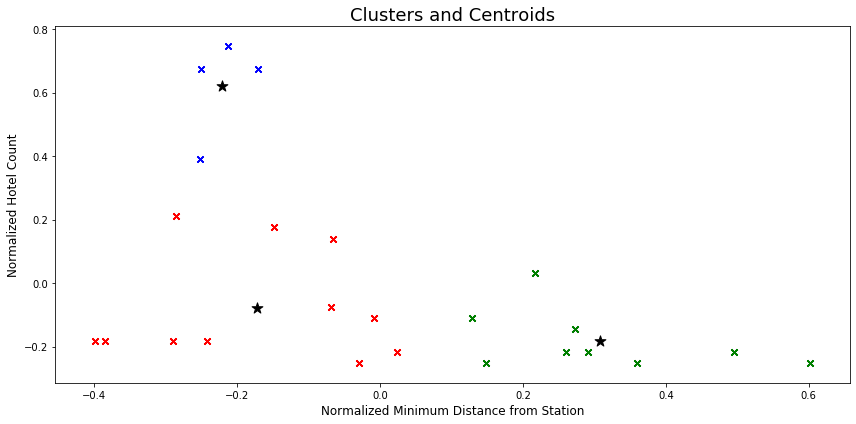

In [70]:

fig, ax = subplots(figsize=(12., 6))
for label in kmeans.labels_:
    plt.scatter(hotel_df[hotel_df['Cluster Label'] == label]['Norm Min Distance from Station'],
                hotel_df[hotel_df['Cluster Label'] == label]['Norm hotel Count'],
                marker='x', color=cluster_colors[label])
for centroid in kmeans.cluster_centers_:
#     print(centroid)
    plt.scatter(centroid[0], centroid[1], s=130, marker="*", color='black')
ax.set_xlabel('Normalized Minimum Distance from Station', fontsize=12)
ax.set_ylabel('Normalized Hotel Count', fontsize=12)
plt.title('Clusters and Centroids', fontsize='18')
plt.tight_layout()
plt.show()

##### Show the Metro stations that correspond to each cluster

### Cluster 1 (AVERAGE potential)

* Although not a prohibitive metro station to open a hotel in its vicinity, there is already a fair number of hotels in the area and the nearest one is not far from the metro station

In [71]:
hotel_df.loc[hotel_df['Cluster Label'] == 0]

,station,Cluster Label,lat,lng,Min Distance from Station,Hotels Count,Norm Min Distance from Station,Norm hotel Count
4,Barakhamba Road Metro Station,0,28.629993,77.223830,267,13,-0.148330,0.175595
5,Patel Nagar Metro Station,0,28.645115,77.169256,345,6,-0.067751,-0.074405
6,Patel Chowk Metro Station,0,28.622511,77.213679,347,12,-0.065685,0.139881
7,Janpath Metro Station,0,28.624426,77.219187,135,14,-0.284694,0.211310
10,Khan Market Metro Station,0,28.602285,77.227860,130,3,-0.289859,-0.181548
12,Lajpat Nagar Metro Station,0,28.570607,77.236510,403,5,-0.007834,-0.110119
13,Jangpura Metro Station,0,28.583052,77.239316,176,3,-0.242338,-0.181548
15,Kaushambi Metro Station,0,28.645475,77.324144,434,2,0.024191,-0.217262
17,Indira Gandhi International Airport Metro Station,0,28.555696,77.086223,25,3,-0.398330,-0.181548
21,Uttam Nagar East Metro Station,0,28.624648,77.065229,383,1,-0.028495,-0.252976


### Cluster 2 (LOW potential)
* There are already many existing hotels in the area and the nearest hotels is in most cases in a relatively short distance from the metro station

In [72]:
hotel_df.loc[hotel_df['Cluster Label'] == 2]

,station,Cluster Label,lat,lng,Min Distance from Station,Hotels Count,Norm Min Distance from Station,Norm hotel Count
0,Rajiv Chowk | राजीव चौक Metro Station,2,28.632981,77.219288,167,19,-0.251636,0.389881
1,New Delhi | नई दिल्ली Metro Station,2,28.642803,77.223351,205,29,-0.212379,0.747024
19,Airport Express Line Metro Station,2,28.549347,77.120869,169,27,-0.249570,0.675595
23,Delhi Aerocity Airport Metro Express Station,2,28.548632,77.120558,246,27,-0.170024,0.675595


### Cluster 3 (HIGH potential)
* There are only few  already existing hotels in the area and the nearest hotels is in most cases relatively not in a short distance to the metro station

In [73]:
hotel_df.loc[hotel_df['Cluster Label'] == 1]

,station,Cluster Label,lat,lng,Min Distance from Station,Hotels Count,Norm Min Distance from Station,Norm hotel Count
2,Central Secretariat Metro Station,1,28.615908,77.212558,621,9,0.217373,0.032738
3,Kashmere Gate Metro Station,1,28.667746,77.228304,759,1,0.359935,-0.252976
8,Jama Masjid Metro Station,1,28.649631,77.237812,536,5,0.129563,-0.110119
9,Race Course Metro Station,1,28.596674,77.211206,692,2,0.290720,-0.217262
11,Azadpur | आजादपुर Metro Station,1,28.654047,77.129642,993,1,0.601670,-0.252976
14,Hauz Khas | हौज खास Metro Station,1,28.543979,77.206263,675,4,0.273158,-0.145833
16,Janak Puri East Metro Station,1,28.632935,77.086751,890,2,0.495265,-0.217262
18,Mansarover Park Metro Station,1,28.675370,77.300932,555,1,0.149191,-0.252976
20,Malviya Nagar Metro Station,1,28.528696,77.204997,662,2,0.259728,-0.217262


#  DISCUSSION

###### Clusters of areas (in our case Metro stations) were identified as groups of similar in their potential locations for opening a hotel



###### Possible areas that were not in the Foursquare database should also be examined so that it can be determined if it is just lack of data about these stations or indeed there are no hotels in the vicinity of the stations. A lot more factors can be considered when choosing an appropriate location. Some examples of extra factors can be:

* Area near Airport side so travelling connecting people can wait at airport or take a room in hotel
* Population density in the area
* Per day rent in this area is this area expensive or not 
* Near by surrouding Airport
* Number of people daily visitng this area
* Property prices in the area
* Number of businesses operating in the area 
* Final decission on optimal hotel location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.



#  Conclusion

* The above results can be a good starting point for a prospective businessman that is interested in opening a hotel. Similar methodology can be used for other types of businesses probably with customized criteria.

* Delhi is Main city in India ,and mostly all connecting international flights go from Delhi Airport .so many people can stay in this hotel this area is near to airport area and only few hotels are there .

* Due to few hotels their is more chance to ppeople can book their.

* With the availability of a number of different tools and Machine Learning algorithms, it is possible to find solutions (or possible solutions) to an ever increasing number of problems and queries.

* And it is getting better and better!


# References

* Karol Bagh - Wikipedia
* Google ( many postal code are NaN so for cleaning the data)
* Forsquare API(To find near by metro station and minimum distance between each hotel to metro)
* Google Map 
* K-Mean Cluster